In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, from_json, substring, when, length, split, lit
from pyspark.sql.types import StructType, StructField, StringType
from pyspark import StorageLevel

In [2]:
# Nomes de aquivos e pastas
csv_pj = 'dataset/empresas_estabelecimentos_30m.csv'
parquet_nodes = 'dataset/grapho/nodes_30m'
parquet_dir_name = 'output/embeddings_nome_30m'
investigaCEP='71200'

In [3]:
spark = SparkSession.builder \
        .config("spark.driver.memory", "128g") \
        .appName("investiga_nome") \
        .getOrCreate()

23/12/12 22:16:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
pj = spark.read.parquet(parquet_nodes)

In [5]:
# Carrega embeddings
nomes_pj = spark.read.parquet(parquet_dir_name)

In [6]:
cnpjs_filtrados = pj \
    .filter(col("te_dados_es.cep").startswith(investigaCEP)) \
    .select("id")

# Filtrando 'nomes_pj' com base nos CNPJs filtrados
nomes_filtrados = nomes_pj.join(cnpjs_filtrados, nomes_pj["id"] == pj["id"], "inner") \
                          .select(nomes_pj["id"], nomes_pj["nomeFantasia"],  nomes_pj["embeddings"])
nomes_filtrados.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[id: string, nomeFantasia: string, embeddings: array<float>]

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Converter os embeddings para um formato compatível com o cosine_similarity
embeddings = np.array(nomes_filtrados.select("embeddings").collect())
embeddings =  np.vstack(embeddings)
# print(embeddings)
# Calcular a matriz de similaridade usando cosine_similarity
matriz_similaridade = cosine_similarity(embeddings, embeddings)

# Imprimir a matriz de similaridade
print(matriz_similaridade)

[[1.         0.47017828 0.6572433  ... 0.53168014 0.55016469 0.29590055]
 [0.47017828 1.         0.45855387 ... 0.47479737 0.46399492 0.3458229 ]
 [0.6572433  0.45855387 1.         ... 0.65080884 0.7462316  0.2298464 ]
 ...
 [0.53168014 0.47479737 0.65080884 ... 1.         0.66094679 0.32367916]
 [0.55016469 0.46399492 0.7462316  ... 0.66094679 1.         0.22648076]
 [0.29590055 0.3458229  0.2298464  ... 0.32367916 0.22648076 1.        ]]


In [8]:
inter_x = 0
inter_y = 30
nova_matriz_similaridade = matriz_similaridade[inter_x:inter_y, inter_x:inter_y]

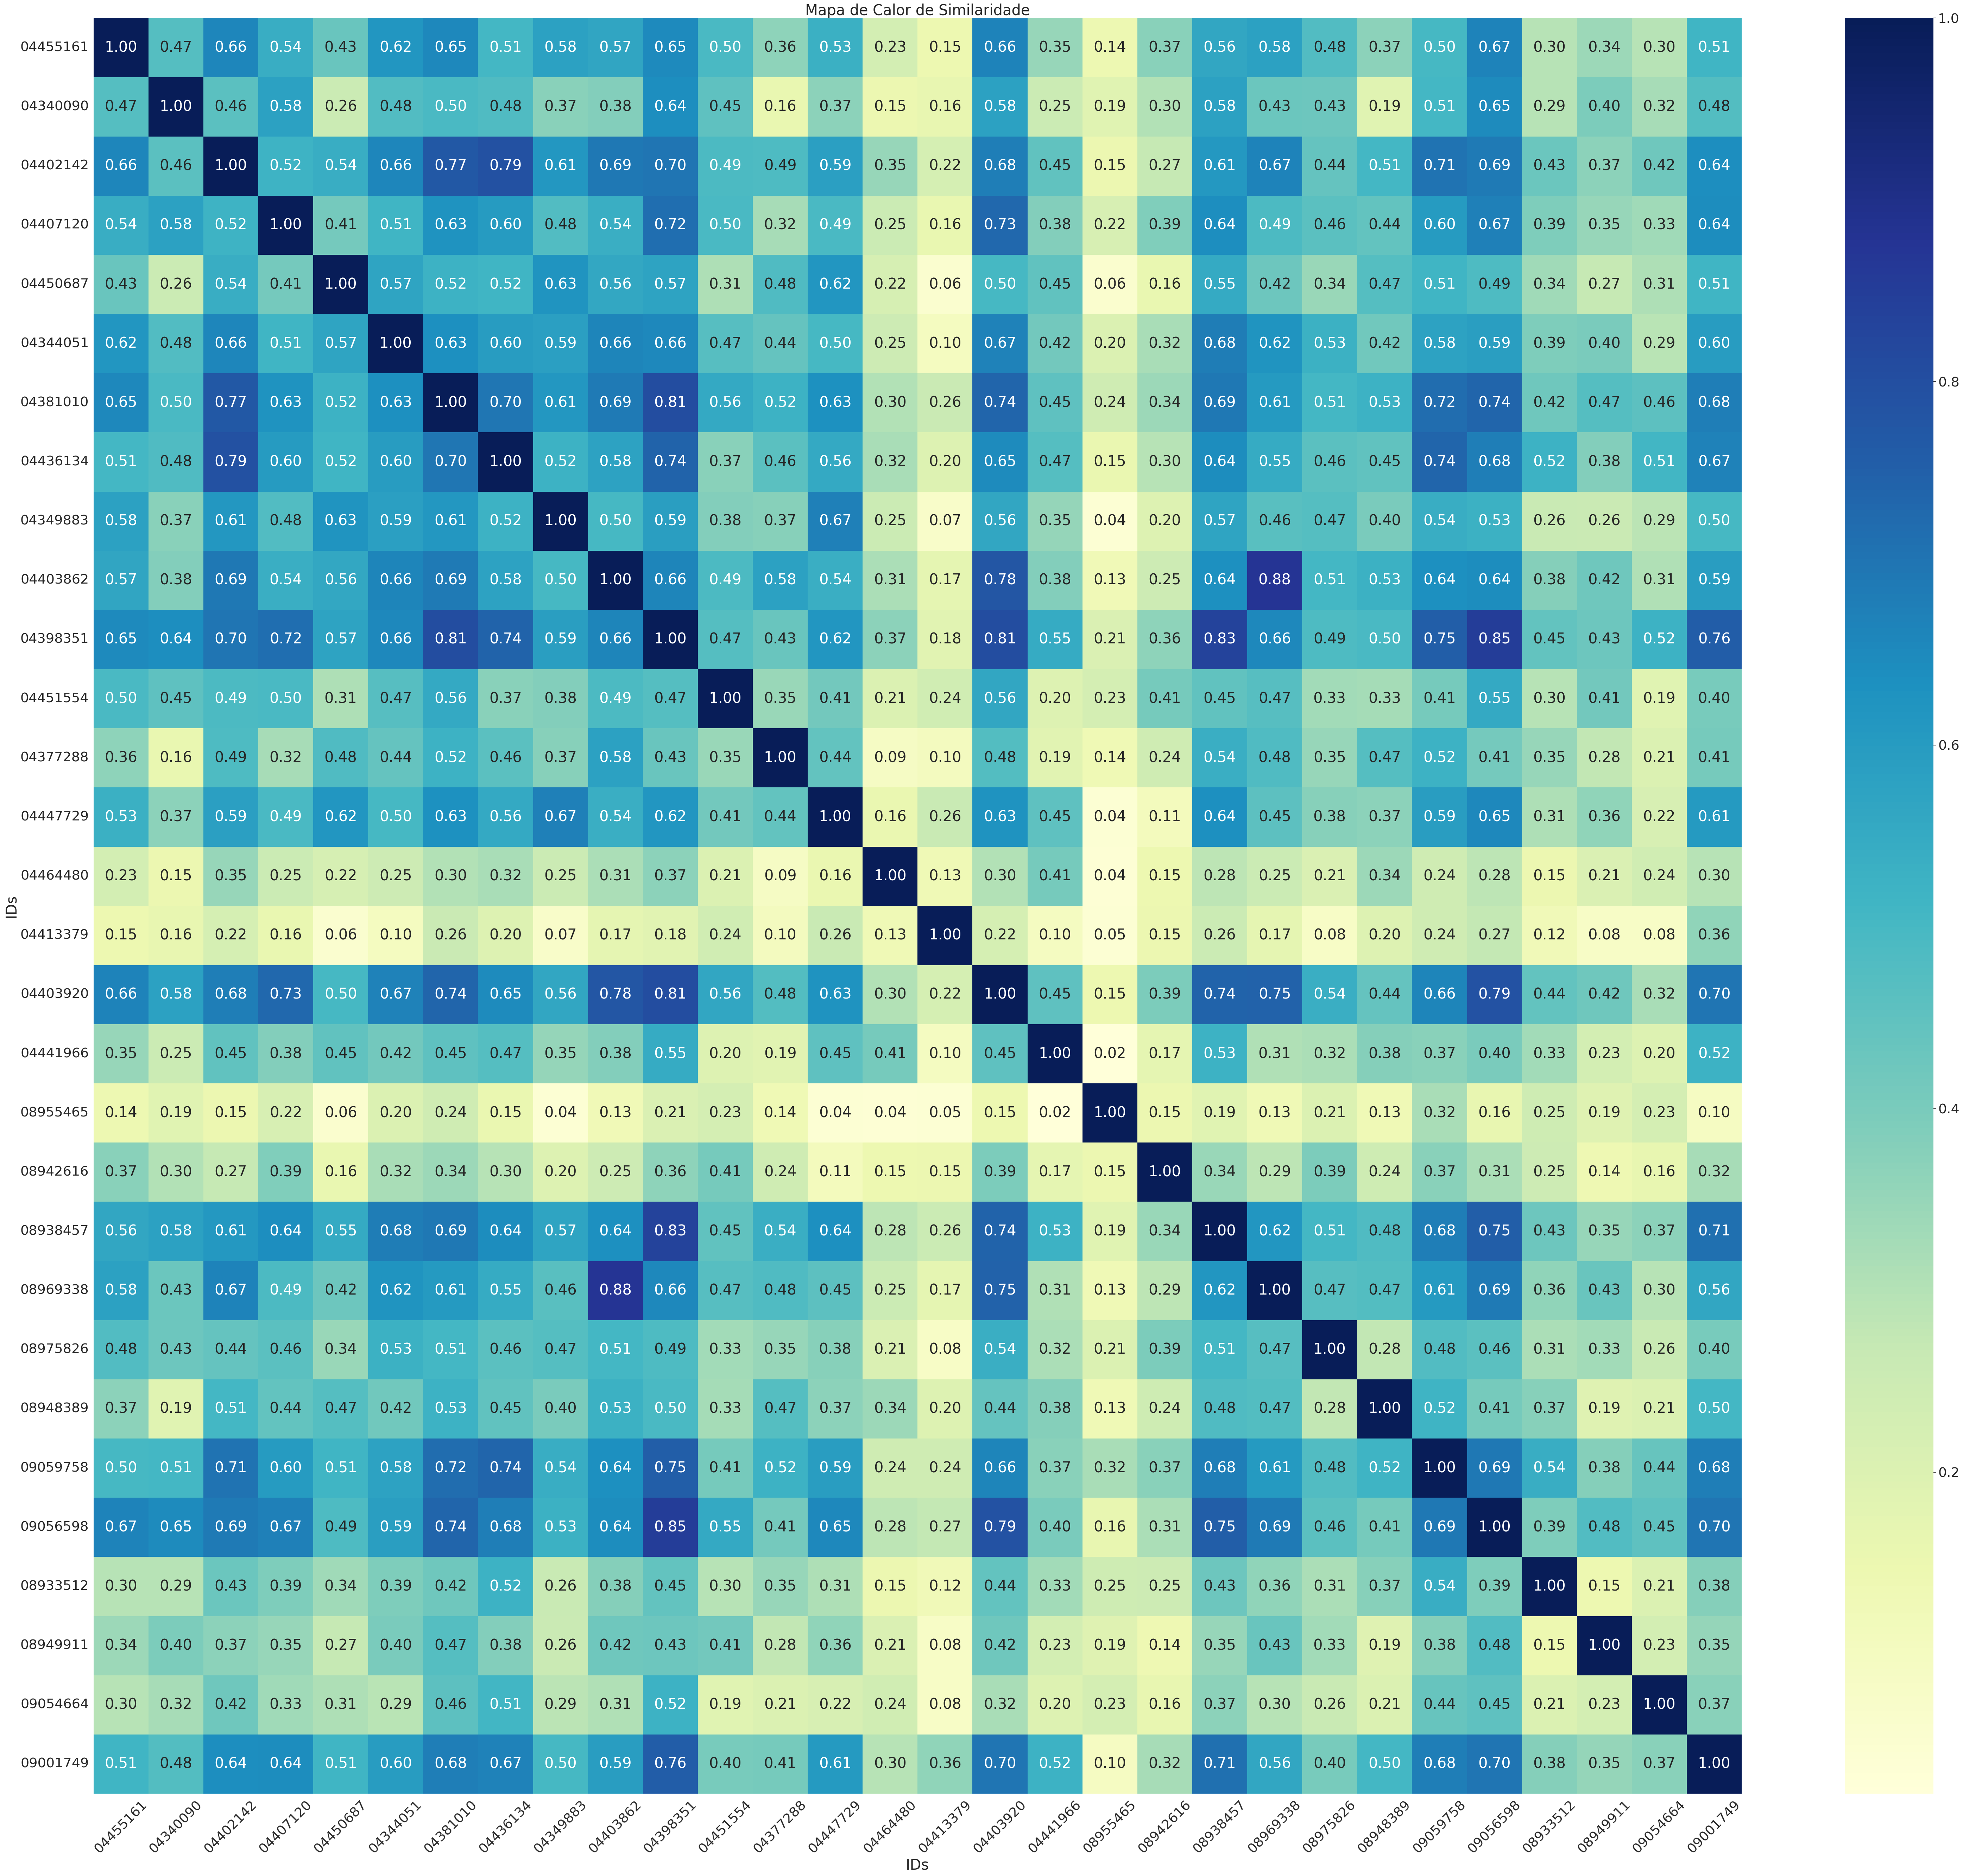

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtendo os IDs dos nomes filtrados
ids = nomes_filtrados.select("id").rdd.flatMap(lambda x: x).collect()[inter_x:inter_y]

# Plotando o mapa de calor da matriz de similaridade
sns.set(style="white")  # Configuração do estilo do plot
plt.figure(figsize=(62, 54))  # Definindo o tamanho da figura

# Criando o mapa de calor
sns.set(font_scale=2.5)
ax = sns.heatmap(nova_matriz_similaridade, annot=True, fmt=".2f", xticklabels=ids, yticklabels=ids, cmap="YlGnBu")

# Configurações adicionais
plt.title('Mapa de Calor de Similaridade')
plt.xlabel('IDs')
plt.ylabel('IDs')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Mostrando o mapa de calor
plt.show()

In [13]:
import numpy as np

n = 100

# Criar uma máscara para a diagonal e abaixo dela
mask = np.triu(np.ones(matriz_similaridade.shape), k=1).astype(bool)

# Aplicar a máscara para ignorar a diagonal e valores abaixo dela
valores_acima_diagonal = matriz_similaridade[mask]

# Encontrar os índices dos n maiores valores acima da diagonal
indices_maior_valor = np.argsort(valores_acima_diagonal)[-n:][::-1]

# Obter os valores e suas coordenadas na matriz de similaridade
valores_maior_valor = valores_acima_diagonal[indices_maior_valor]
coordenadas = np.argwhere(mask)

# Imprimir os n maiores valores e suas coordenadas acima da diagonal
for i in range(n):
    idx = coordenadas[indices_maior_valor[i]]
    print(f"Valor: {valores_maior_valor[i]}, Coordenada: {idx[0]}, {idx[1]}")

Valor: 1.0000000000000018, Coordenada: 3196, 3434
Valor: 1.0000000000000018, Coordenada: 1118, 3196
Valor: 1.0000000000000018, Coordenada: 1118, 3434
Valor: 1.0000000000000016, Coordenada: 2125, 3194
Valor: 1.0000000000000016, Coordenada: 2114, 3194
Valor: 1.0000000000000016, Coordenada: 500, 3021
Valor: 1.0000000000000016, Coordenada: 2114, 2125
Valor: 1.0000000000000013, Coordenada: 3389, 3684
Valor: 1.0000000000000013, Coordenada: 2570, 3684
Valor: 1.0000000000000013, Coordenada: 932, 3284
Valor: 1.0000000000000013, Coordenada: 1218, 3729
Valor: 1.0000000000000013, Coordenada: 2372, 3197
Valor: 1.0000000000000013, Coordenada: 2570, 3389
Valor: 1.000000000000001, Coordenada: 1795, 1822
Valor: 1.000000000000001, Coordenada: 1401, 1822
Valor: 1.000000000000001, Coordenada: 3590, 3869
Valor: 1.000000000000001, Coordenada: 2104, 3652
Valor: 1.000000000000001, Coordenada: 1577, 1866
Valor: 1.000000000000001, Coordenada: 1552, 1867
Valor: 1.000000000000001, Coordenada: 1401, 1795
Valor: 1.

In [11]:
# Imprimir os n maiores valores, suas coordenadas e os campos 'id' e 'nomeFantasia' correspondentes no DataFrame 'nomes_filtrados'
for i in range(n):
    idx = coordenadas[indices_maior_valor[i]]
    idx_x, idx_y = idx[0], idx[1]
    
    # Acessar os campos 'id' e 'nomeFantasia' com base nos índices na matriz de similaridade
    id_x = nomes_filtrados.select("id").collect()[idx_x]['id']
    nome_x = nomes_filtrados.select("nomeFantasia").collect()[idx_x]['nomeFantasia']
    id_y = nomes_filtrados.select("id").collect()[idx_y]['id']
    nome_y = nomes_filtrados.select("nomeFantasia").collect()[idx_y]['nomeFantasia']
    
    print(f"Valor: {valores_maior_valor[i]}, Coordenada: {idx_x}, {idx_y}")
    print(f"Par de nomes: ({id_x}, {nome_x}) e ({id_y}, {nome_y})")

Valor: 1.0000000000000018, Coordenada: 3196, 3434
Par de nomes: (13014839, CHAMPION) e (12382467, CHAMPION)
Valor: 1.0000000000000018, Coordenada: 1118, 3196
Par de nomes: (19046025, CHAMPION) e (13014839, CHAMPION)
Valor: 1.0000000000000018, Coordenada: 1118, 3434
Par de nomes: (19046025, CHAMPION) e (12382467, CHAMPION)
Valor: 1.0000000000000016, Coordenada: 2125, 3194
Par de nomes: (27270949, NATURAL BRASIL COMERCIO DE ALIMENTOS) e (13026472, NATURAL BRASIL COMERCIO DE ALIMENTOS)
Valor: 1.0000000000000016, Coordenada: 2114, 3194
Par de nomes: (07870325, NATURAL BRASIL COMERCIO DE ALIMENTOS) e (13026472, NATURAL BRASIL COMERCIO DE ALIMENTOS)
Valor: 1.0000000000000016, Coordenada: 500, 3021
Par de nomes: (03397439, LEO MOTORS) e (05118017, LEO MOTORS)
Valor: 1.0000000000000016, Coordenada: 2114, 2125
Par de nomes: (07870325, NATURAL BRASIL COMERCIO DE ALIMENTOS) e (27270949, NATURAL BRASIL COMERCIO DE ALIMENTOS)
Valor: 1.0000000000000013, Coordenada: 3389, 3684
Par de nomes: (14328229

In [12]:
spark.stop()